  # Autoencoder - Dev - Copy 2

# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import json
import time
import types, copy, pprint
import logging 
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import shutil
import getpass
import yaml

from matplotlib import pyplot as plt
from typing import Dict, List, Tuple
from scipy.sparse import csr_matrix
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
print(torch.__version__)

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

WANDB_ACTIVE = True

os.environ["WANDB_NOTEBOOK_NAME"] = "Autoencoder_dev.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import wandb
from KevinsRoutines.utils.utils_wandb  import  init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general  import  list_namespace 

timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print('Timestamp: ',timestamp)
# logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
# FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
# logging.basicConfig(level="INFO", format= FORMAT)
# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y%m%d_%H%M%S'))

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']
2.2.1+cu118
Timestamp:  2024_06_03_13:28:39


In [3]:
 

from snnl.utils import parse_args, get_hyperparameters, set_global_seed, get_device, set_device
from snnl.utils import load_model, save_model, import_results, export_results, save_checkpoint, load_checkpoint 
from snnl.utils import plot_model_parms, plot_train_history, plot_train_metrics
from snnl.utils import display_epoch_metrics, display_cellpainting_batch
from snnl.utils import CellpaintingDataset, InfiniteDataLoader, custom_collate_fn
from snnl.utils import display_model_summary
from snnl.utils import save_checkpoint_v2, load_checkpoint_v2

from dev_base import Model
from dev_dnn  import DNN 
from dev_autoencoder import Autoencoder
from dev_snnloss import SNNLoss

'Sample module for using DNN classifier with SNNL'

In [ ]:
current_device = get_device()
print(f"Current device is : {current_device}")

current_device = set_device(0)

### main(args)

In [7]:
# if __name__ == "__main__":
input_args = f" --seed               1234 " \
             f" --runmode            snnl" \
             f" --configuration      hyperparameters/autoencoder_cellpainting-100.yaml"
             # f" --configuration    hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())
args

with open(args.configuration) as f:
    args = types.SimpleNamespace(**yaml.safe_load(f), **(vars(args)))
args.batch_size = args.cellpainting_args['batch_size']
args.compounds_per_batch = args.cellpainting_args['compounds_per_batch']
set_global_seed(args.seed)


Namespace(seed=1234, runmode='snnl', configuration='hyperparameters/autoencoder_cellpainting-2.yaml')

## Define dataset and dataloaders

In [8]:
trn_file_sz = args.cellpainting_args['train_end'] - args.cellpainting_args['train_start']
val_file_sz = args.cellpainting_args['val_end'] - args.cellpainting_args['val_start']
smp_sz = args.cellpainting_args['sample_size']
buf_sz = args.cellpainting_args['compounds_per_batch']
bth_sz = args.cellpainting_args['batch_size']
recs_per_batch = smp_sz * bth_sz * buf_sz

for file_sz in [trn_file_sz, val_file_sz]:
    bth_per_epoch = file_sz // recs_per_batch
    print(f" - Each mini-batch contains {recs_per_batch/smp_sz} compounds with {smp_sz} samples per each compound : total {recs_per_batch} rows")
    print(f" - Number of {recs_per_batch} row full size batches per epoch: {bth_per_epoch}")
    print(f" - Rows covered by {bth_per_epoch} full size batches ({recs_per_batch} rows) per epoch:  {(file_sz // recs_per_batch) * recs_per_batch}")
    print(f" - Last partial batch contains : {file_sz % recs_per_batch} rows")
    print() 

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 800
 - Rows covered by 800 full size batches (300 rows) per epoch:  240000
 - Last partial batch contains : 0 rows

 - Each mini-batch contains 100.0 compounds with 3 samples per each compound : total 300 rows
 - Number of 300 row full size batches per epoch: 80
 - Rows covered by 80 full size batches (300 rows) per epoch:  24000
 - Last partial batch contains : 0 rows



In [9]:
#### Load CellPainting Dataset
if args.dataset == 'cellpainting':
    print(f" load {args.dataset}")
    train_dataset = CellpaintingDataset(type='train',    **args.cellpainting_args)
    train_loader = InfiniteDataLoader(dataset=train_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)
    val_dataset = CellpaintingDataset(type='val',    **args.cellpainting_args)
    val_loader = InfiniteDataLoader(dataset=val_dataset, batch_size = args.batch_size, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

# for idx, batch in enumerate(train_loader):
#     print(f"{idx:4d}, {batch[0].shape}, {batch[1].shape},{batch[2].shape},{batch[3].shape},{batch[4].shape}, {batch[3][:3]}, {batch[3][-3:]}")
#     display_cellpainting_batch(idx, batch)
#     if idx >= 0:
#         break

 load cellpainting
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    _init()_    -- type :             train
    _init()_    -- start :            0
    _init()_    -- end :              240000
    _init()_    -- numrows :          240000
 Building CellPantingDataset from NOTEBOOK
    _init()_    -- filename:          /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    _init()_    -- type :             val
    _init()_    -- start :            0
    _init()_    -- end :              24000
    _init()_    -- numrows :          24000


In [10]:
args.project_name = 'CellPainting_Profiles'
args.exp_title = 'snglOpt-100Ltnt'
args.exp_desc = 'Autoencoder Training in SNNL mode - Single Optimizer, 100 dim latent layer'+' - '+args.exp_title

args.exp_id   = None
args.exp_name = 'AE_'+datetime.now().strftime('%m%d_%H%M')
args.exp_date = datetime.now().strftime('%Y%m%d')

## --- for restarts
# args.exp_id   = '0g8w13h6'
# args.exp_name = 'AE_0516_1104'
# args.exp_date = '20240516'
##-----------------
print(f" Experiment name {args.exp_name} - description: {args.exp_desc}")

 Experiment name AE_0516_1104 - description: Autoencoder Training in SNNL mode - Single Optimizer, 100 dim latent layer - snglOpt-100Ltnt


In [11]:
if WANDB_ACTIVE:
    wandb_run = init_wandb(args)

    args.exp_id = wandb_run.id
    print(f" run id is : {args.exp_id}")

 initiate new job run


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Autoencoder_dev.ipynb.
wandb: Currently logged in as: kbardool. Use `wandb login --relogin` to force relogin


 WandB Initialization -----------------------------------------------------------
 PROJECT NAME: CellPainting_Profiles
 RUN ID      : 0g8w13h6 
 RUN NAME    : AE_0516_1104
 RUN NOTES   : brief description
 --------------------------------------------------------------------------------


In [12]:
args.exp_id = wandb_run.id
print(f" run id is : {args.exp_id}")

 run id is : 0g8w13h6


# Define autoencoder model

## Override arguments

In [13]:
args.show_every = 1
args.save_every = 25
args.temperature   = 0.8
args.loss_factor   = 2.0        ## 2.0e+00
args.snnl_factor   = 0.5       ## 1.0e+00
args.learning_rate = 1.0e-03    ## 0.001
args.temperatureLR = 1.0e-04    ## 1e-4
print(f"   Latent dim        {args.code_units}")
print(f"   loss_factor       {args.loss_factor}")
print(f"   snnl_factor       {args.snnl_factor}")
print(f"   temperature       {args.temperature}")
print(f"   learning_rate     {args.learning_rate}")
print(f"   temperatureLR:    {args.temperatureLR}")
type(args.learning_rate)

   Latent dim        100
   loss_factor       2.0
   snnl_factor       0.5
   temperature       0.8
   learning_rate     0.001
   temperatureLR:    0.0001


float

In [14]:
list_namespace(args)


command line parms : 
-----------------------
activations..............  ['relu', 'relu', 'sigmoid', 'relu', 'relu', 'relu']
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  100
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_start................  0
    validation_path..........  /home/kevin/WSL-shared/Cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv

code_units...............  100
compounds_per_batch..

## Define Model

In [ ]:
model = define_autoencoder_model(args, embedding_layer = 4, device = current_device)
model.device

In [15]:
# if args.runmode.lower() == "baseline":
#     print(f"Defining model in baseline mode")
#     model = Autoencoder(
#         mode = "autoencoding",
#         units=args.units,
#         activations = args.activations,
#         embedding_layer = 4,
#         code_units  = args.code_units, 
#         input_shape = args.input_shape, 
#         sample_size = args.cellpainting_args['sample_size'],
#         criterion   = torch.nn.MSELoss(reduction='mean'),
#         loss_factor = args.loss_factor,
#         learning_rate=args.learning_rate,
#         adam_weight_decay = 0,
#         use_scheduler = True,
        
#         use_snnl = False,
#         snnl_factor= 0.0,
#         use_temp_scheduler = False
#         )
# elif args.runmode.lower() == "snnl":
#     print(f"Defining model in SNNL mode ")
#     model = Autoencoder(
#         mode="latent_code",
#         units=args.units,
#         activations = args.activations,
#         embedding_layer = 4,
#         code_units = args.code_units,
#         input_shape=args.input_shape,
#         sample_size = args.cellpainting_args['sample_size'],
#         criterion = torch.nn.MSELoss(reduction='mean'),
#         loss_factor = args.loss_factor,
#         learning_rate=args.learning_rate,
#         adam_weight_decay = 0,
#         use_scheduler = True,
        
#         use_snnl=True,
#         snnl_factor=args.snnl_factor,
#         temperature=args.temperature,
#         temperatureLR=args.temperatureLR,
#         use_annealing= False,        
#         use_sum = False,
#         SGD_weight_decay= 0,
#         use_temp_scheduler = False
#         )
# else:
#     raise ValueError("Choose runmode between [baseline] and [snnl] only.")
# model.device

Defining model in SNNL mode 
    Model_init()_    -- AE - support for unsupervised in latent_code mode is True
    layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
    layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    2  type:linear           input:   1024  output:    128    weights: [128, 1024]   
    layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    4  type:linear           input:    128  output:    100    weights: [100, 128]   
    layer pair:    5  type:linear           input:    100  output:    128    weights: [128, 100]   
    layer pair:    6  type:relu             input:      0  output:      0    weights: [0, 0]   
    layer pair:    7  type:linear           input:    128  output:   1024    weights: [1024, 128]   
    layer pair:    8  type:relu             input:      0  output:      0    weights: [0, 0]   
 

/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


device(type='cuda', index=0)

In [17]:
if WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [16]:
# display_model_summary(model)
# model.optimizer
# model.scheduler.__dict__
# model.temp_scheduler.__dict__

# Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [ ]:
# epoch = -1
# filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
# print(filename)
# save_checkpoint_v2(epoch, model, filename) 

In [ ]:
starting_epoch, epochs = 0, 50
starting_epoch, epochs

print(f" run epochs {starting_epoch+1} to {epochs} ")

In [34]:
# snnl_factor = 10.0
# print(f" loss_factor         : {model.loss_factor}")
# print(f" snnl_factor         : {model.snnl_factor}")
# print(f" model.monitor_grads_layer: {model.monitor_grads_layer}")
# print(f" model.temperature : {model.temperature}")
# print(f" Learning rate     : {model.optimizer.param_groups[0]['lr']}") 
# print(f" Temperature LR    : {model.temperatureLR}") 
# model.temperature = 40.0
# model.snnl_factor = 0.5
# model.loss_factor = 0.1
# model.temperatureLR = 1e-4
# model.optimizer.param_groups[0]['lr'] = 0.001
# model.temp_optimizer.param_groups[0]['lr'] = 0.000005
# model.monitor_grads_layer = -2
print()
print(f" loss_factor         : {model.loss_factor}")
print(f" monitor_grads_layer : {model.monitor_grads_layer}")
# print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" Learning rate       : {args.learning_rate}") 
print(f" Learning rate       : {model.optimizer.param_groups[0]['lr']}") 
print(f" Use Scheduler       : {model.use_scheduler}") 
print()
if model.use_snnl:
    print(f" Use snnl            : {model.use_snnl}") 
    print(f" snnl_factor         : {model.snnl_factor}")
    print(f" temperature         : {model.temperature.item()}")
    print(f" Temperature LR      : {model.optimizer.param_groups[1]['lr']}") 
    # print(f" Temperature LR      : {model.temp_optimizer.param_groups[0]['lr']}") 
    print(f" Use Temp Scheduler  : {model.use_temp_scheduler}") 
    print(f" Temp Scheduler      : {model.temp_scheduler}") 
print(f"\n run epochs {starting_epoch+1} to {epochs} ")
wandb.config.update(args)


 loss_factor         : 0.1
 monitor_grads_layer : None
 Learning rate       : 0.001
 Learning rate       : 6.25e-05
 Use Scheduler       : True

 Use snnl            : True
 snnl_factor         : 0.5
 temperature         : 0.03800183907151222
 Temperature LR      : 6.25e-06
 Use Temp Scheduler  : False
 Temp Scheduler      : None

 run epochs 301 to 400 


In [42]:
print(f"{datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {starting_epoch+1:4d} of {epochs:4d}")
header = True

for epoch in range(starting_epoch,epochs):
    train_loss = model.epoch_train(train_loader, epoch)
    val_loss = model.epoch_validate(val_loader, epoch)
    
    display_epoch_metrics(model, epoch, epochs, header)
    header = False
    model.scheduling_step(val_loss)
    
    if WANDB_ACTIVE:
        epoch_metrics = {x:y[-1] for x,y in model.training_history['val'].items()} | \
                        {x:y[-1] for x,y in model.training_history['trn'].items()} 
        wandb_log_metrics( data = epoch_metrics, step = epoch)
    
    if (epoch + 1) % args.save_every == 0:
        filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
        save_checkpoint_v2(epochs, model, filename, update_latest=False, update_best=False)    

20240604_122125  epoch  401 of  450
                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |    LR       temp LR  |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
12:23:27 ep 401 /450 |   0.972855    0.063361    0.909495 |   0.032382   -4.2700e+00 |                          |   1.950861    0.062817    1.888044 |                          |  0.000016   0.000002 |
12:25:28 ep 402 /450 |   0.970254    0.063420    0.906834 |   0.032336   -4.2609e+00 |                          |   1.962160    0.063600    1.898560 |                          |  0.000016   0.000002 |
12:27:31 ep 403 /450 |   0.985231    0.064719    0.920512 |   0.032038   -3.4043e+00 |                          |   1.919164    0.063341    1.855823 |          

In [36]:
20240516_212634  epoch  201 of  225
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |    LR       temp LR  |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
20:53:12 ep 201 /225 |   1.622590    0.096130    1.526460 |   0.040682   -2.6735e+00 |                          |   2.041688    0.096553    1.945135 |                          |  0.001000   0.000000 |
21:12:53 ep 202 /225 |   2.033023    0.098166    1.934857 |   0.040682   -2.6735e+00 |                          |   2.026608    0.096553    1.930055 |                          |  0.001000   0.000000 |
21:28:58 ep 203 /225 |   2.030048    0.098165    1.931883 |   0.040682   -2.6735e+00 |                          |   2.014337    0.096552    1.917785 |                          |  0.001000   0.000000 |
21:31:20 ep 204 /225 |   2.018031    0.098165    1.919866 |   0.040682   -2.6735e+00 |                          |   2.005755    0.096552    1.909202 |                          |  0.001000   0.000000 |
21:33:43 ep 205 /225 |   2.015474    0.098165    1.917308 |   0.040682   -2.6735e+00 |                          |   2.014628    0.096552    1.918076 |                          |  0.001000   0.000000 |
21:36:06 ep 206 /225 |   2.013515    0.098165    1.915350 |   0.040682   -2.6735e+00 |                          |   2.006223    0.096552    1.909671 |                          |  0.001000   0.000000 |
21:38:30 ep 207 /225 |   2.014119    0.098165    1.915954 |   0.040682   -2.6735e+00 |                          |   2.018567    0.096552    1.922014 |                          |  0.001000   0.000000 |
21:40:52 ep 208 /225 |   2.014196    0.098165    1.916030 |   0.040682   -2.6735e+00 |                          |   2.043070    0.096552    1.946518 |                          |  0.001000   0.000000 |
21:43:15 ep 209 /225 |   2.014429    0.098165    1.916264 |   0.040682   -2.6735e+00 |                          |   2.032726    0.096552    1.936174 |                          |  0.001000   0.000000 |
21:45:38 ep 210 /225 |   2.019220    0.098165    1.921054 |   0.040682   -2.6735e+00 |                          |   2.038110    0.096552    1.941558 |                          |  0.001000   0.000000 |
21:48:00 ep 211 /225 |   2.026048    0.098165    1.927882 |   0.040682   -2.6735e+00 |                          |   2.057853    0.096552    1.961300 |                          |  0.001000   0.000000 |
21:50:22 ep 212 /225 |   2.030529    0.098165    1.932364 |   0.040682   -2.6735e+00 |                          |   2.047821    0.096552    1.951268 |                          |  0.001000   0.000000 |
21:52:44 ep 213 /225 |   2.034312    0.098165    1.936146 |   0.040682   -2.6735e+00 |                          |   2.041985    0.096552    1.945432 |                          |  0.001000   0.000000 |
21:55:06 ep 214 /225 |   2.033762    0.098165    1.935597 |   0.040682   -2.6735e+00 |                          |   2.034619    0.096553    1.938066 |                          |  0.001000   0.000000 |
21:57:29 ep 215 /225 |   2.034387    0.098165    1.936222 |   0.040682   -2.6735e+00 |                          |   2.025657    0.096553    1.929104 |                          |  0.001000   0.000000 |
21:59:51 ep 216 /225 |   2.034575    0.098165    1.936410 |   0.040682   -2.6735e+00 |                          |   2.054923    0.096553    1.958371 |                          |  0.001000   0.000000 |
22:02:13 ep 217 /225 |   2.034685    0.098165    1.936520 |   0.040682   -2.6735e+00 |                          |   2.051646    0.096553    1.955093 |                          |  0.001000   0.000000 |
22:04:35 ep 218 /225 |   2.030721    0.098165    1.932555 |   0.040682   -2.6735e+00 |                          |   2.042200    0.096553    1.945648 |                          |  0.001000   0.000000 |
22:06:58 ep 219 /225 |   2.030696    0.098165    1.932530 |   0.040682   -2.6735e+00 |                          |   2.033971    0.096553    1.937419 |                          |  0.001000   0.000000 |
22:09:22 ep 220 /225 |   2.032065    0.098165    1.933900 |   0.040682   -2.6735e+00 |                          |   2.047361    0.096553    1.950809 |                          |  0.001000   0.000000 |
22:11:46 ep 221 /225 |   2.031688    0.098165    1.933523 |   0.040682   -2.6735e+00 |                          |   2.033589    0.096553    1.937037 |                          |  0.001000   0.000000 |
22:14:09 ep 222 /225 |   2.031657    0.098165    1.933492 |   0.040682   -2.6735e+00 |                          |   2.047579    0.096553    1.951026 |                          |  0.001000   0.000000 |
22:16:33 ep 223 /225 |   2.030223    0.098165    1.932057 |   0.040682   -2.6735e+00 |                          |   2.035200    0.096553    1.938648 |                          |  0.001000   0.000000 |
22:18:56 ep 224 /225 |   2.032448    0.098165    1.934282 |   0.040682   -2.6735e+00 |                          |   2.060573    0.096553    1.964020 |                          |  0.001000   0.000000 |
22:21:21 ep 225 /225 |   2.031878    0.098165    1.933712 |   0.040682   -2.6735e+00 |                          |   2.047663    0.096553    1.951110 |                          |  0.001000   0.000000 |
                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |    LR       temp LR  |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
09:58:37 ep 276 /300 |   1.068973    0.061938    1.007035 |   0.037330   -2.1261e+00 |                          |   1.872861    0.061432    1.811430 |                          |  0.000063   0.000006 |
10:00:46 ep 277 /300 |   1.064203    0.061750    1.002452 |   0.037145   -2.0004e+00 |                          |   1.885816    0.061332    1.824484 |                          |  0.000063   0.000006 |
10:02:54 ep 278 /300 |   1.074985    0.062426    1.012559 |   0.037551   -1.7335e+00 |                          |   1.896110    0.062159    1.833952 |                          |  0.000063   0.000006 |
10:05:02 ep 279 /300 |   1.066916    0.062666    1.004250 |   0.037370   -2.2499e+00 |                          |   1.898452    0.062385    1.836067 |                          |  0.000063   0.000006 |
10:07:10 ep 280 /300 |   1.078825    0.063319    1.015506 |   0.037283   -1.0941e+00 |                          |   1.880240    0.063334    1.816906 |                          |  0.000063   0.000006 |
10:09:19 ep 281 /300 |   1.076995    0.063517    1.013478 |   0.037296   -1.9437e+00 |                          |   1.883126    0.063138    1.819988 |                          |  0.000063   0.000006 |
10:11:27 ep 282 /300 |   1.072156    0.063491    1.008665 |   0.037271   -2.1288e+00 |                          |   1.910302    0.063009    1.847293 |                          |  0.000063   0.000006 |
10:13:36 ep 283 /300 |   1.067264    0.063236    1.004028 |   0.036979   -2.0603e+00 |                          |   1.897057    0.062705    1.834352 |                          |  0.000063   0.000006 |
10:15:44 ep 284 /300 |   1.067284    0.063082    1.004202 |   0.036727   -2.3189e+00 |                          |   1.893834    0.062898    1.830937 |                          |  0.000063   0.000006 |
10:17:53 ep 285 /300 |   1.065673    0.063252    1.002421 |   0.036725   -2.2381e+00 |                          |   1.903851    0.062791    1.841059 |                          |  0.000063   0.000006 |
10:20:02 ep 286 /300 |   1.059498    0.063259    0.996239 |   0.036930   -3.4402e+00 |                          |   1.934760    0.063562    1.871198 |                          |  0.000063   0.000006 |
10:22:11 ep 287 /300 |   1.061353    0.063563    0.997790 |   0.037030   -2.5070e+00 |                          |   1.901176    0.063109    1.838067 |                          |  0.000063   0.000006 |
10:24:20 ep 288 /300 |   1.068606    0.063771    1.004835 |   0.037308   -2.0811e+00 |                          |   1.906999    0.063434    1.843565 |                          |  0.000063   0.000006 |
10:26:28 ep 289 /300 |   1.073835    0.064179    1.009655 |   0.037890   -1.7923e+00 |                          |   1.907491    0.063481    1.844010 |                          |  0.000063   0.000006 |
10:28:36 ep 290 /300 |   1.070205    0.063919    1.006286 |   0.037681   -1.9316e+00 |                          |   1.898326    0.063413    1.834913 |                          |  0.000063   0.000006 |
10:30:44 ep 291 /300 |   1.069842    0.064003    1.005840 |   0.037461   -2.7729e+00 |                          |   1.910304    0.063213    1.847090 |                          |  0.000063   0.000006 |
10:32:52 ep 292 /300 |   1.066961    0.063803    1.003158 |   0.037546   -2.9752e+00 |                          |   1.898340    0.062987    1.835353 |                          |  0.000063   0.000006 |
10:35:00 ep 293 /300 |   1.066073    0.063654    1.002419 |   0.037717   -3.0780e+00 |                          |   1.902566    0.063132    1.839434 |                          |  0.000063   0.000006 |
10:37:09 ep 294 /300 |   1.065592    0.063678    1.001914 |   0.037720   -2.2688e+00 |                          |   1.900946    0.063210    1.837736 |                          |  0.000063   0.000006 |
10:39:18 ep 295 /300 |   1.066193    0.064058    1.002135 |   0.037672   -3.2518e+00 |                          |   1.915173    0.063755    1.851419 |                          |  0.000063   0.000006 |
10:41:25 ep 296 /300 |   1.077860    0.064369    1.013491 |   0.038018   -2.0600e+00 |                          |   1.910969    0.063797    1.847172 |                          |  0.000063   0.000006 |
10:43:32 ep 297 /300 |   1.077412    0.064511    1.012901 |   0.038268   -2.5505e+00 |                          |   1.914119    0.065058    1.849061 |                          |  0.000063   0.000006 |
10:45:40 ep 298 /300 |   1.079623    0.064395    1.015228 |   0.038671   -1.7901e+00 |                          |   1.899654    0.063745    1.835908 |                          |  0.000063   0.000006 |
10:47:48 ep 299 /300 |   1.074565    0.064313    1.010252 |   0.038423   -1.3871e+00 |                          |   1.888048    0.066227    1.821821 |                          |  0.000063   0.000006 |
10:49:55 ep 300 /300 |   1.067694    0.064201    1.003493 |   0.038002   -1.9886e+00 |                          |   1.890348    0.063822    1.826526 |                          |  0.000063   0.000006 |

ckpts/AE_snnl_20240516_snglOpt-100Ltnt_ep_225.pt
[INFO] Model exported to ckpts/AE_snnl_20240516_snglOpt-100Ltnt_ep_225.pt.


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2662659682.py, line 9)

In [47]:
starting_epoch, epochs 

(400, 450)

In [41]:
# starting_epoch = 350
# epochs = 375
starting_epoch = epochs
epochs += 50
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 401 to 450 


In [48]:
for epoch in range(epochs):
    display_epoch_metrics(model, epoch)

                     |   Trn_loss    PrimLoss      SNNL   |    temp*        grad     |                          |   Vld_loss    PrimLoss      SNNL   |                          |    LR       temp LR  |
---------------------+------------------------------------+--------------------------+--------------------------+------------------------------------+--------------------------|----------------------|
11:09:12 ep   1 /450 |   3.465524    1.115392    2.350131 |   0.691694    2.2006e-01 |                          |   3.165826    0.908445    2.257381 |                          |  0.001000   0.000100 |
11:11:29 ep   2 /450 |   3.042320    0.850718    2.191602 |   0.585908    3.0617e-01 |                          |   2.982546    0.820577    2.161968 |                          |  0.001000   0.000100 |
11:13:47 ep   3 /450 |   2.916127    0.801041    2.115086 |   0.482896    4.1804e-01 |                          |   2.909591    0.819025    2.090566 |                          |  0.001000   0.0001

In [ ]:
if WANDB_ACTIVE:
    wandb_run.finish()
    WANDB_ACTIVE = False

# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

In [ ]:
# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

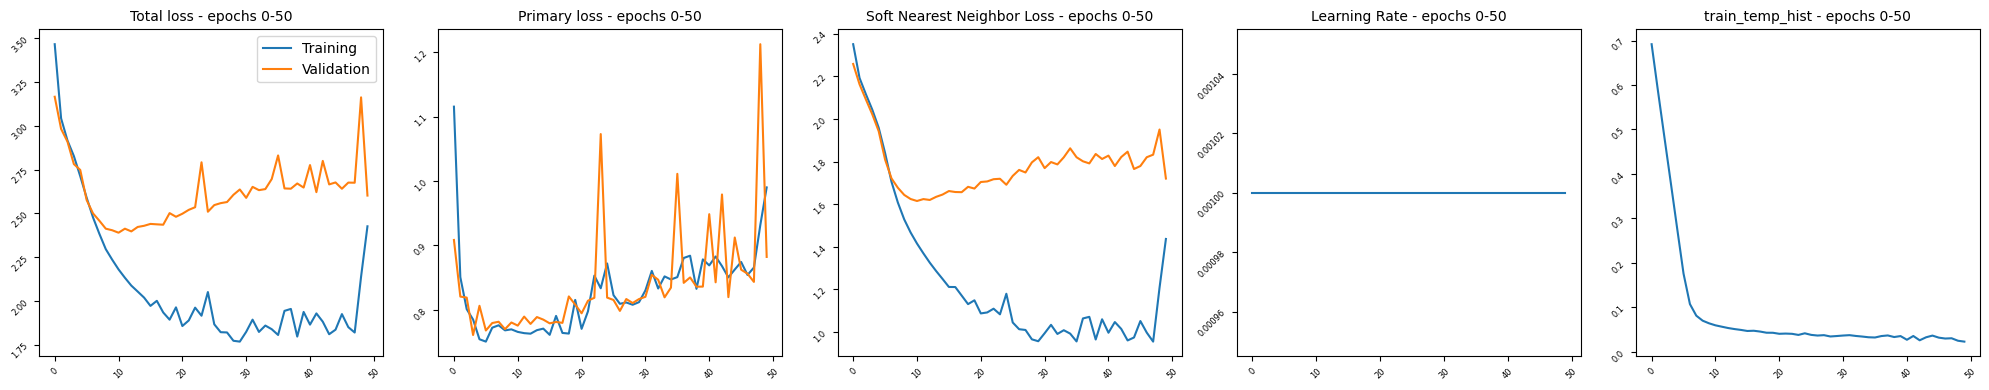

In [25]:
plot_train_history(model, start= 0, n_bins = 25)

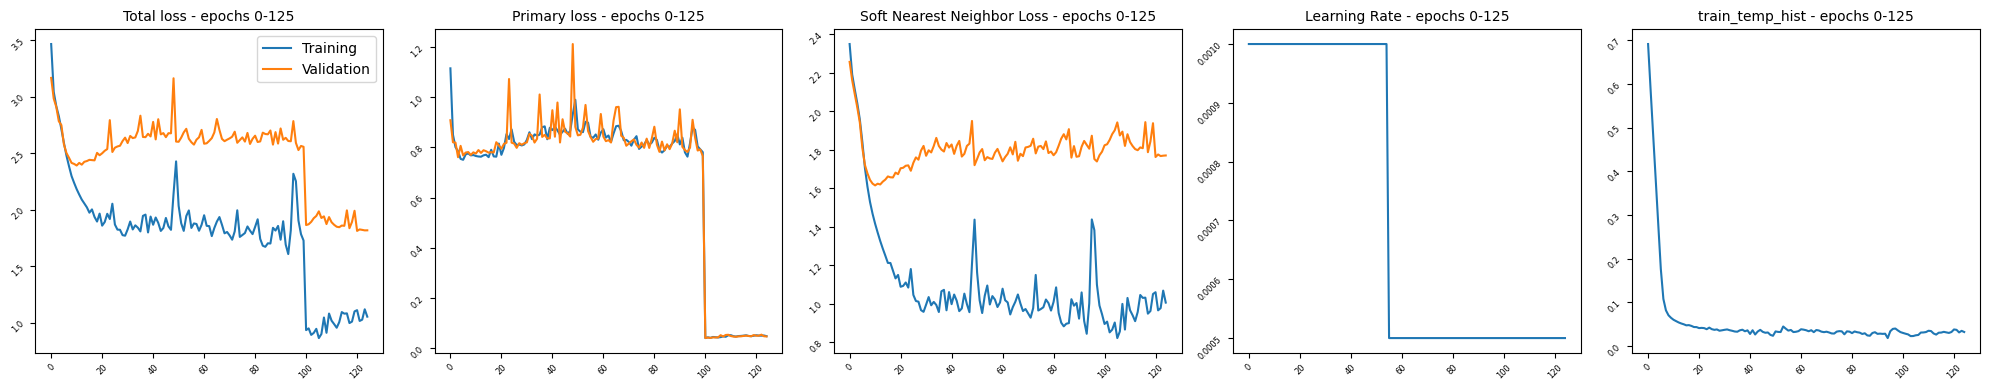

In [41]:
plot_train_history(model, start= 0, n_bins = 25)

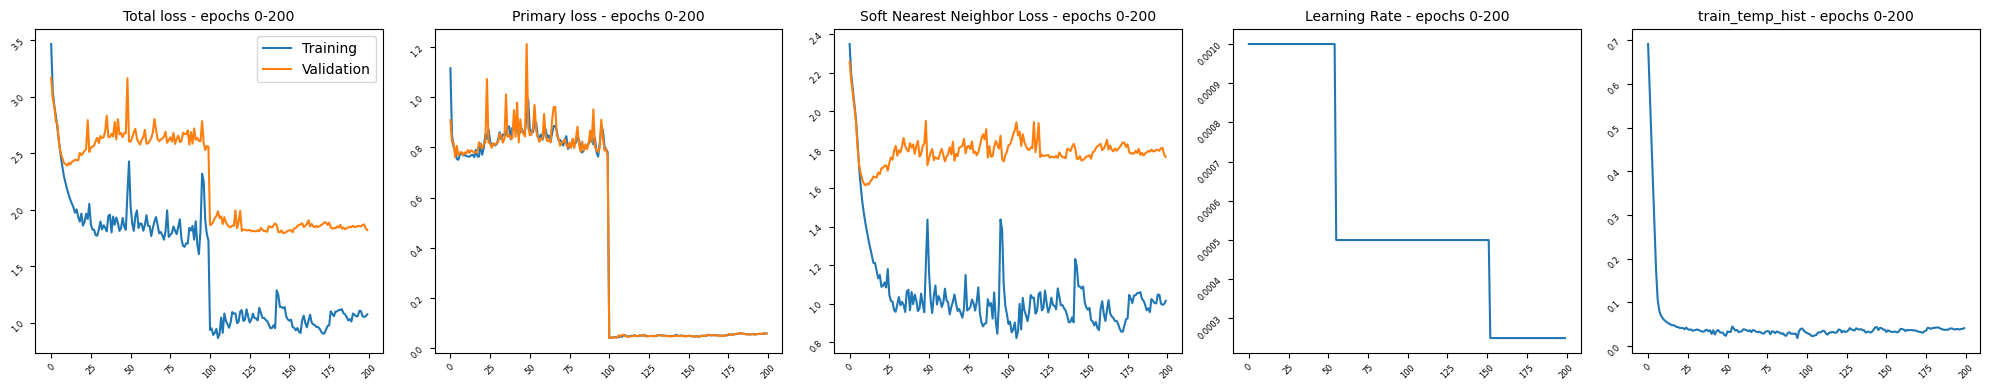

In [48]:
plot_train_history(model, start= 0, n_bins = 25)

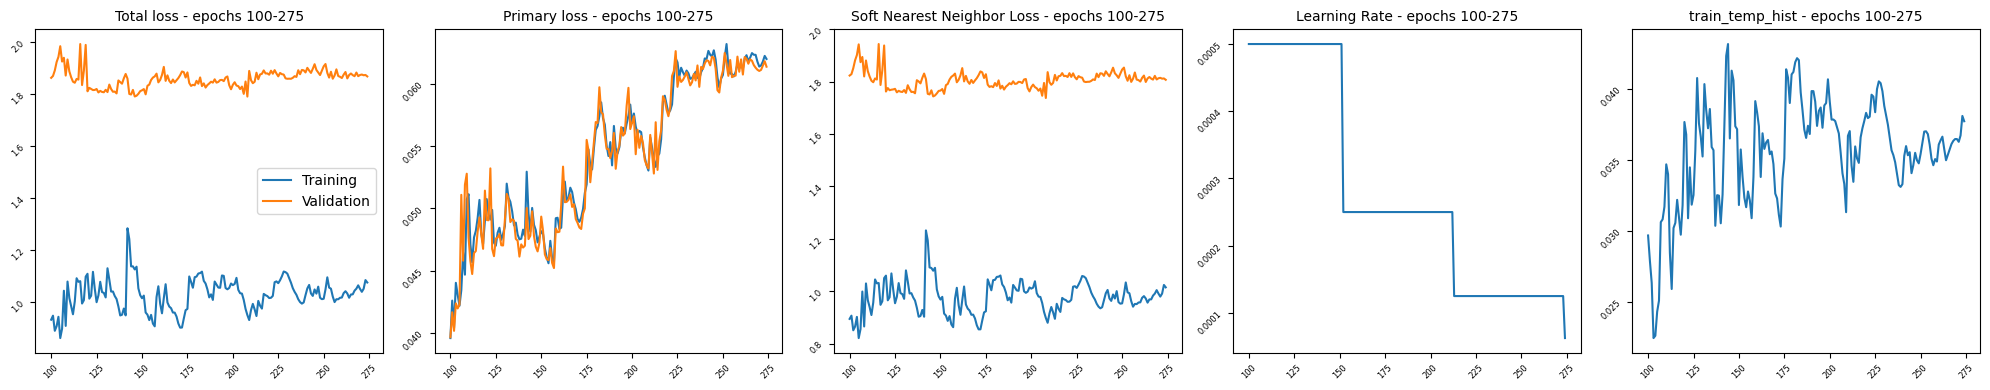

In [45]:
plot_train_history(model, start= 100, n_bins = 25)

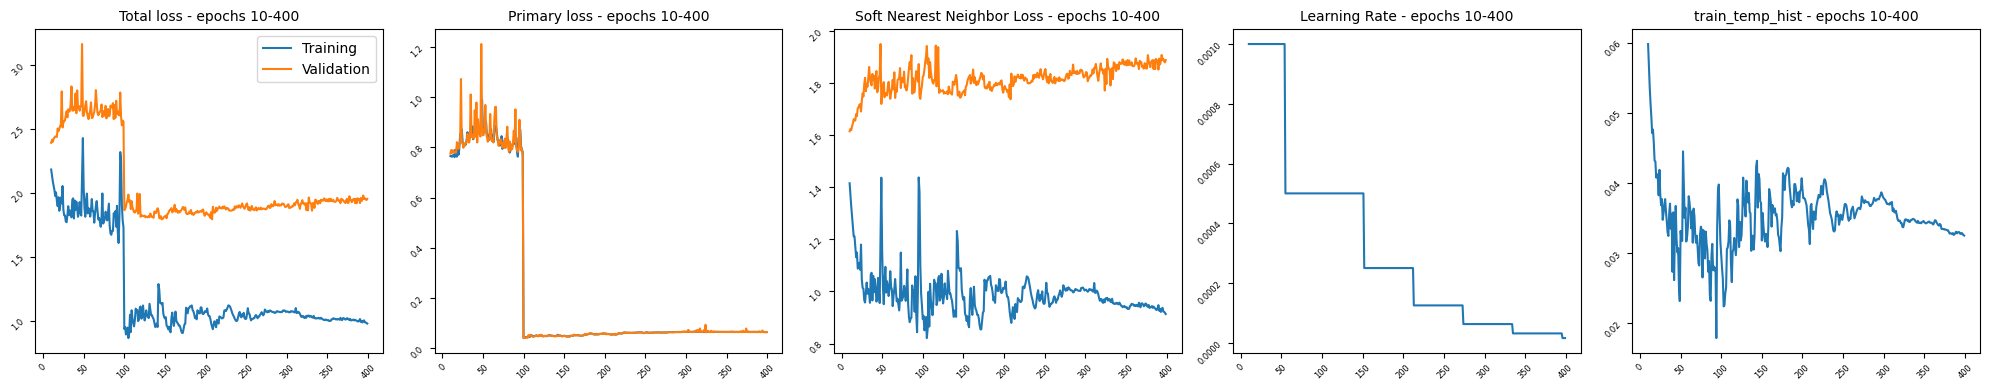

In [38]:
plot_train_history(model, start= 10, n_bins = 25)

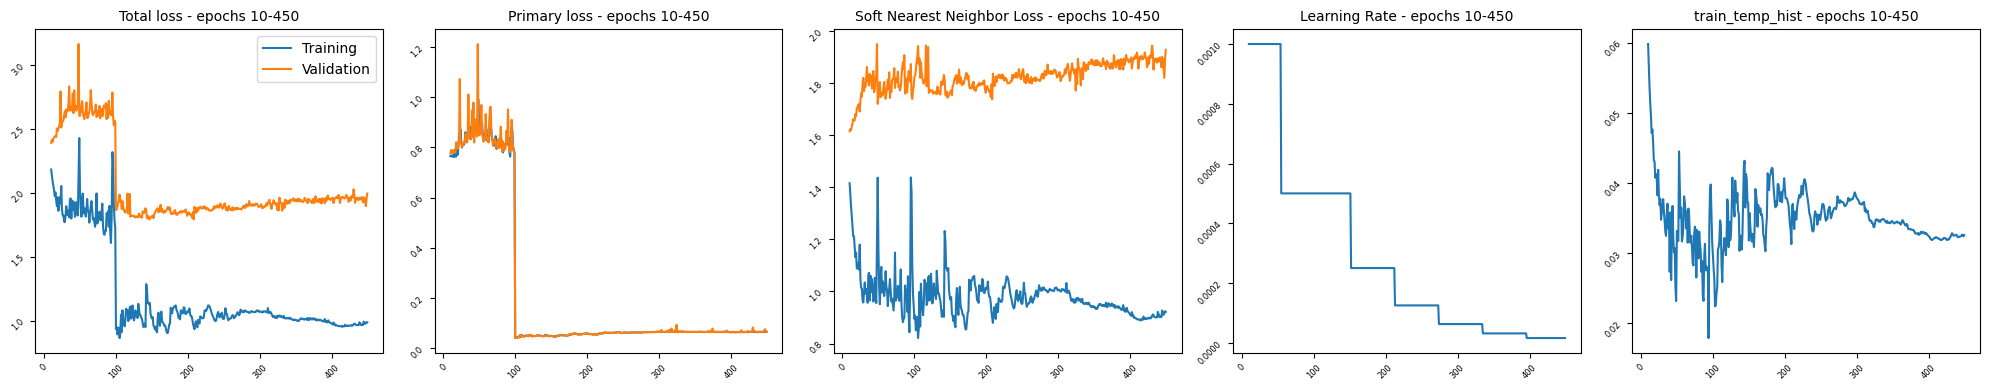

In [49]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_model_parms(model, epochs= epochs, n_bins = 15)

In [ ]:
from snnl.utils import plot_regression_metrics
# plot_train_metrics(model, n_bins = 25)
plot_regression_metrics(model, n_bins = 25)

# Save model results and model

In [ ]:
# import datetime.timezone
# datetime.timetz()
compounds_per_batch = cellpainting_args['compounds_per_batch']
title="autoencoder"
epochs_num = epochs
timestamp = datetime.now().strftime('%Y%m%d')
filename = f"AE_{args.model.lower()}_{timestamp}_{title}_{epochs_num:03d}_cpb_{compounds_per_batch}_factor_{int(snnl_factor):d}"
print(f"saved to {filename}")

In [ ]:
# save_model(model, filename)
# export_results(model=model, filename=filename)
# save_checkpoint(epochs, model, filename, update_latest=False, update_best=False)

In [ ]:
model.name
args.runmode
ex_timestamp
ex_title
epoch
args.compounds_per_batch
model.snnl_factor

In [ ]:
filename = f"{model.name}_{args.runmode}_{args.exp_date}_{args.exp_title}_ep_{epoch+1:03d}"
print(filename)

In [ ]:
filename = f"{model.name}_{args.model.lower()}_{ex_timestamp}_{ex_title}_{epoch+1:03d}_cpb_{args.compounds_per_batch}_copy"
print(filename)
    # export_results(model=model, filename=filename)
save_checkpoint_2(epochs, model, filename, update_latest=False, update_best=False)  

# Load model

In [18]:
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240509'
ex_title = args.exp_title
compounds_per_batch = args.compounds_per_batch


In [80]:
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}.pt"
print(filename)
file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_ep_*.pt"
print(file_pattern)

AE_baseline_20240605_snglOpt-50Ltnt_300.pt
AE_baseline_20240605_snglOpt-50Ltnt_ep_*.pt


In [81]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
epochlist =sorted([int(x[-6:-3]) for x in filelist])
epochlist
 

['AE_baseline_20240605_snglOpt-50Ltnt_ep_025.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_050.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_075.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_100.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_125.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_150.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_175.pt',
 'AE_baseline_20240605_snglOpt-50Ltnt_ep_200.pt']

[25, 50, 75, 100, 125, 150, 175, 200]

In [82]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

In [20]:
filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"   
if filename[-3:] != '.pt':
    filename+='.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

AE_snnl_20240516_snglOpt-100Ltnt_ep_300.pt

 *** Checkpoint EXISTS *** 



In [21]:
mdl , last_epoch = load_checkpoint_v2(model, filename)  
print(f" last epoch : {last_epoch}")

--> AE_snnl_20240516_snglOpt-100Ltnt_ep_300.pt
epoch                                   , <class 'int'>                                                 -- model attr set
state_dict                              , <class 'collections.OrderedDict'>                             -- model attr set
optimizer                               , <class 'torch.optim.adam.Adam'>                               -- model attr set
temp_optimizer                          , <class 'NoneType'>                                            -- model attr set
optimizer_state_dict                    , <class 'dict'>                                                -- model attr set
temp_optimizer_state_dict               , <class 'NoneType'>                                            -- model attr set
scheduler                               , <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>          -- model attr set
temp_scheduler                          , <class 'NoneType'>                                       

In [87]:
print(current_device)
print(model.device)
model.device = current_device
print(model.device)

cuda:1
cuda:0
cuda:1


In [22]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

cuda:0


Autoencoder(
  (primary_criterion): MSELoss()
  (snnl_criterion): SNNLoss()
  (layers): ModuleList(
    (0): Linear(in_features=1471, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=1024, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1024, out_features=1471, bias=True)
  )
)

In [152]:
starting_epoch, epochs, 

(75, 100)

In [25]:
print(f" last epoch  {last_epoch}")

 last epoch  300


In [26]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

 run epochs 301 to 400 


In [27]:
print()
print(f" model device         : {model.device}")
print(f" model temperature    : {model.temperature}")
print() 
print(f" loss_factor          : {model.loss_factor}")
print(f" monitor_grads_layer  : {model.monitor_grads_layer}")
print(f" Learning rate        : {model.optimizer.param_groups[0]['lr']}") 
print(f" snnl_factor          : {model.snnl_factor}")
if model.use_snnl:
    print(f" temperature          : {model.temperature.item()}")
if model.temp_optimizer is not None:
    print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
print()

for th_key in ['trn', 'val']:
    for k,v in model.training_history[th_key].items():
        if isinstance(v[-1],str):
            print(f" {k:20s} : {v[-1]:s}  ")
        else:
            print(f" {k:20s} : {v[-1]:6f} ")
    print()



 model device         : cuda:0
 model temperature    : Parameter containing:
tensor([0.0380], device='cuda:0', requires_grad=True)

 loss_factor          : 0.1
 monitor_grads_layer  : None
 Learning rate        : 6.25e-05
 snnl_factor          : 0.5
 temperature          : 0.03800183907151222

 trn_time             : 10:49:44  
 trn_ttl_loss         : 1.067694 
 trn_prim_loss        : 0.064201 
 trn_snn_loss         : 1.003493 
 trn_lr               : 0.000063 
 temp_hist            : 0.038002 
 temp_grad_hist       : -1.988630 
 temp_lr              : 0.000006 

 val_time             : 10:49:55  
 val_ttl_loss         : 1.890348 
 val_prim_loss        : 0.063822 
 val_snn_loss         : 1.826526 



In [28]:
model.optimizer.__dict__
print()

{'defaults': {'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None},
 '_optimizer_step_pre_hooks': OrderedDict(),
 '_optimizer_step_post_hooks': OrderedDict(),
 '_optimizer_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_state_dict_post_hooks': OrderedDict(),
 '_optimizer_load_state_dict_pre_hooks': OrderedDict(),
 '_optimizer_load_state_dict_post_hooks': OrderedDict(),
 '_zero_grad_profile_name': 'Optimizer.zero_grad#Adam.zero_grad',
 'state': defaultdict(dict,
             {Parameter containing:
              tensor([[-0.1214, -0.0768,  0.2475,  ..., -0.5189, -0.1092, -0.2146],
                      [ 0.0809,  0.0357,  0.1907,  ...,  0.0875,  0.3319, -0.0033],
                      [-0.0516, -0.0157, -0.3819,  ...,  0.1690,  0.2524,  0.1727],
                      ...,
                      [-0.0221, -0.0293,  0.1409,  ..., -0.1536,  0

In [30]:
model.scheduler.__dict__

{'factor': 0.5,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 6.25e-05
     maximize: False
     weight_decay: 0
 
 Parameter Group 1
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 6.25e-06
     maximize: False
     weight_decay: 0
 ),
 'min_lrs': [0, 0],
 'patience': 50,
 'verbose': True,
 'cooldown': 10,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 1e-06,
 'threshold_mode': 'rel',
 'best': 0.03966052299365401,
 'num_bad_epochs': 16,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 300,
 '_last_lr': [6.25e-05, 6.25e-06]}

In [29]:
model.temp_optimizer.__dict__
print()

AttributeError: 'NoneType' object has no attribute '__dict__'

In [31]:
model.temp_scheduler.__dict__

AttributeError: 'NoneType' object has no attribute '__dict__'

# Misc code

In [ ]:
# loaded_data = import_results(filename)

# for k in loaded_data.keys():
#     print(k, type(loaded_data[k]), len(loaded_data[k]))
# print("\nTraining History")
# results = loaded_data['training_history']
# for k,v in results.items():
#     print(' ',k , len(v))
#     for kk,vv in results[k].items():
#         print( f"   {kk:20s} {len(vv)}")
# print("\nModel Parameters")
# model_parameters = loaded_data['params']
# for k,v in model_parameters.items():
#     print(f"   {k:25s} {v}" )
 

In [ ]:
# model_attributes = model.__dict__
# from collections import defaultdict
# output = defaultdict(dict)

# for key, value in model_attributes.items():
#         if key[0] == "_" or type(value) in [torch.device, torch.optim.Adam , torch.optim.SGD]:
#             continue
#         if key == 'training_history':
#             output[key] = value
#         else:
#             output['params'][key] = value
#             print(f" {key:30s}    {type(value)}   ")

# output.keys()
# output['params']
# output['training_history'].keys()

In [ ]:
# for k in results.keys():
#     print(f" key: {k:30s}  length of - loaded results: {len(results[k])}  existing model: {len(model.__dict__[k])}" )
#     model.__dict__[k] = results[k]

In [44]:
# for key in ['trn', 'val']:
#     del_keys = []
#     for k,v in model.training_history[key].items():
#         print(k, len(v))
#         if len(v) == 0 :
#             del_keys.append(k)
#     del_keys
#     for k in del_keys:    
#         del  model.training_history[key][k]
#     print('-----------------------')

# model.training_history['val'].keys()
# np.argmin(model.training_history['trn']['trn_ttl_loss']), np.min(model.training_history['trn']['trn_ttl_loss'] )
# np.argmin(model.training_history['trn']['trn_prim_loss']),np.min(model.training_history['trn']['trn_prim_loss']), np.min(model.training_history['trn']['trn_prim_loss'])  / model.loss_factor
# np.argmin(model.training_history['trn']['trn_snn_loss']), np.min(model.training_history['trn']['trn_snn_loss'] ),  np.min(model.training_history['trn']['trn_snn_loss'] ) / model.snnl_factor
# print()
# np.argmin(model.training_history['val']['val_ttl_loss']) , np.min(model.training_history['val']['val_ttl_loss'] )
# np.argmin(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']), np.min(model.training_history['val']['val_prim_loss']) / model.loss_factor
# np.argmin(model.training_history['val']['val_snn_loss']) , np.min(model.training_history['val']['val_snn_loss'] ), np.min(model.training_history['val']['val_snn_loss'] ) / model.snnl_factor

# model.optimizer
# model.optimizer.state_dict()
# model.optimizer.param_groups[0]['lr'], model.optimizer.param_groups[1]['lr']
# model.scheduler.__dict__

# model.temp_optimizer
# model.temp_scheduler.__dict__
# model.temp_scheduler = model._ReduceLROnPlateau(model.temp_optimizer, mode='min', factor=0.75, patience=35, 
                                              # threshold=1.0e-7, threshold_mode='rel', 
                                              # cooldown=15, min_lr=0, eps=1e-08, verbose =True)  
# model.temp_scheduler['patience'] = 35

In [45]:
# temp_params = [p for name, p in model.named_parameters() if 'temperature' in name]
# network_params = [p for name, p in model.named_parameters() if 'temperature' not in name]
# for t in temp_params:
#     t.requires_grad = False 

In [46]:
# model.optimizer = torch.optim.Adam(params = network_params, lr=0.001, weight_decay = 0.1)
# # if self.use_snnl:
# #     self.optimizer.add_param_group({'params': temp_params, 'lr': temperatureLR, 'weight_decay': adam_weight_decay})

# if model.use_scheduler:
#     model.scheduler = model._ReduceLROnPlateau(model.optimizer, mode='min', factor=0.5, patience=40, threshold=0.000001, 
#                                              threshold_mode='rel', cooldown=10, min_lr=0, eps=1e-08, verbose =True) 